# **Multi Layer Perceptron Implementation using PyTorch packages**

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                   # Convert to tensor and normalize to [0,1]
    transforms.Lambda(lambda x: x.view(-1)) # Flatten 28x28 to 784 vector
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim1=500, hidden_dim2=250, hidden_dim3=100, output_dim=10):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output_layer = nn.Linear(hidden_dim3, output_dim)
        self.ReLu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #Input to hidden layer 1
        out_1 = self.ReLu(self.layer1(x))

        # Hidden layer 1 output to hidden layer 2 as input
        out_2 = self.ReLu(self.layer2(out_1))

        # Hidden layer 2 output to hidden layer 3 as input
        out_3 = self.ReLu(self.layer3(out_2))

        # Output layer
        out = self.output_layer(out_3)  # raw logits, no activation here
        return out


In [22]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=15):
    model.train()
    batch_loss_history = []
    epoch_loss_history = []
    total_batches = len(dataloader)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Append batch loss every 200 iterations
            if (i + 1) % 200 == 0:
                batch_loss_history.append(loss.item())

        epoch_avg_loss = running_loss / total_batches
        epoch_loss_history.append(epoch_avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_avg_loss:.4f}")

    return batch_loss_history, epoch_loss_history

In [23]:
def evaluate_model(trained_model, data_loader):
    trained_model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = trained_model(images)
            _, predicted_classes = torch.max(outputs, 1)
            predictions.extend(predicted_classes.numpy())
            true_labels.extend(labels.numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.mean(predictions == true_labels)

    print(f"Accuracy: {accuracy*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(true_labels, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predictions))

    return accuracy

In [24]:
def plot_training_curves(batch_loss_history, epoch_loss_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(batch_loss_history)), batch_loss_history, marker='o')
    plt.title("Training Loss (Every 200 batch updates)")
    plt.xlabel("Batch update count (x200)")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_loss_history)+1), epoch_loss_history, marker='o', color='red')
    plt.title("Average Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:
model_without_regularization = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_regularization.parameters(), lr=0.01, weight_decay=0.0)

Epoch [1/15], Average Loss: 0.2805
Epoch [2/15], Average Loss: 0.1699
Epoch [3/15], Average Loss: 0.1387
Epoch [4/15], Average Loss: 0.1246
Epoch [5/15], Average Loss: 0.1185
Epoch [6/15], Average Loss: 0.1077
Epoch [7/15], Average Loss: 0.0981
Epoch [8/15], Average Loss: 0.0933
Epoch [9/15], Average Loss: 0.0939
Epoch [10/15], Average Loss: 0.0931
Epoch [11/15], Average Loss: 0.0838
Epoch [12/15], Average Loss: 0.0827
Epoch [13/15], Average Loss: 0.0813
Epoch [14/15], Average Loss: 0.0742
Epoch [15/15], Average Loss: 0.0728


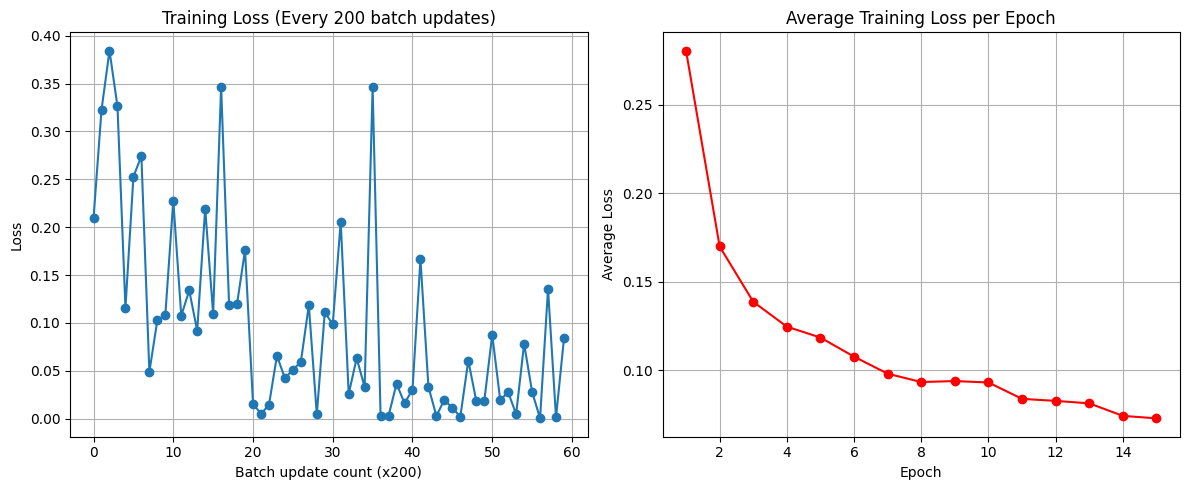

In [27]:
batch_losses, epoch_losses = train_model(model_without_regularization, train_loader, criterion, optimizer, num_epochs=15)
plot_training_curves(batch_losses, epoch_losses)

In [28]:
print("Evaluation on test data for model without L2 regularization:")
evaluate_model(model_without_regularization, test_loader)

Evaluation on test data for model without L2 regularization:
Accuracy: 97.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.97       958
           7       0.99      0.96      0.98      1028
           8       0.93      0.95      0.94       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:
[[ 969    0    0    0    0    0    4    1    6    0]
 [   0 1123    2    2    0    1    2    1    4    0]
 [   8    1  99

np.float64(0.9712)

In [29]:
model_with_L2_1 = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_L2_1.parameters(), lr=0.01, weight_decay= 1e-4)

Epoch [1/15], Average Loss: 0.2796
Epoch [2/15], Average Loss: 0.1811
Epoch [3/15], Average Loss: 0.1732
Epoch [4/15], Average Loss: 0.1576
Epoch [5/15], Average Loss: 0.1497
Epoch [6/15], Average Loss: 0.1417
Epoch [7/15], Average Loss: 0.1422
Epoch [8/15], Average Loss: 0.1360
Epoch [9/15], Average Loss: 0.1352
Epoch [10/15], Average Loss: 0.1372
Epoch [11/15], Average Loss: 0.1366
Epoch [12/15], Average Loss: 0.1316
Epoch [13/15], Average Loss: 0.1291
Epoch [14/15], Average Loss: 0.1328
Epoch [15/15], Average Loss: 0.1324


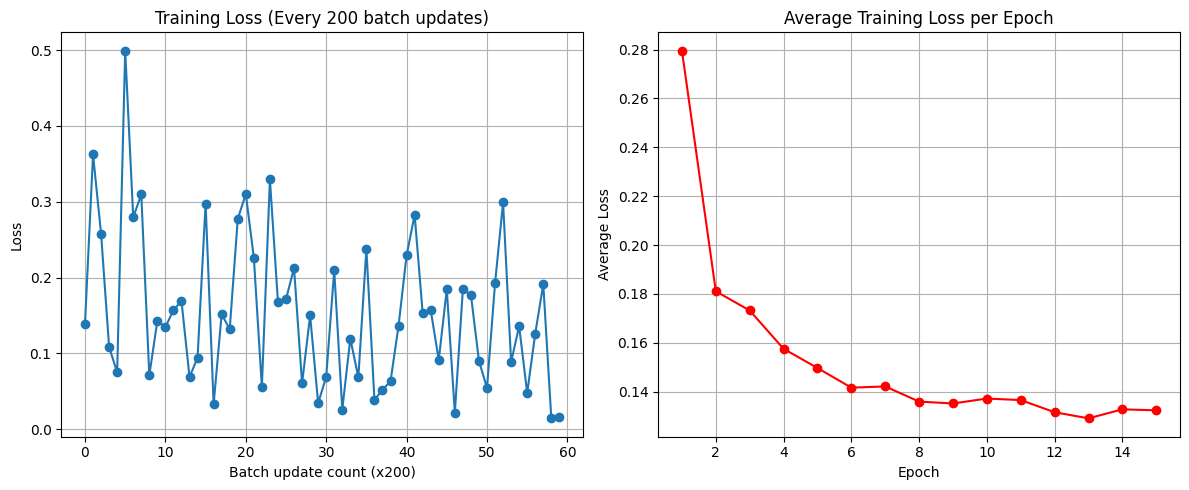

In [30]:
batch_losses_1, epoch_losses_1 = train_model(model_with_L2_1, train_loader, criterion, optimizer, num_epochs=15)
plot_training_curves(batch_losses_1, epoch_losses_1)

In [31]:
print("Evaluation on test data for model with L2 regularization with alpha = 0.0001:")
evaluate_model(model_with_L2_1, test_loader)

Evaluation on test data for model with L2 regularization with alpha = 0.0001:
Accuracy: 95.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.98      0.93      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.94      0.97      0.95       982
           5       0.98      0.91      0.94       892
           6       0.98      0.95      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.90      0.97      0.94       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[ 973    0    1    0    1    1    1    1    2    0]
 [   0 1111    2    3    1    0    0    1   17    0

np.float64(0.9594)

In [32]:
model_with_L2_2 = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_L2_2.parameters(), lr=0.01, weight_decay= 0.01)

Epoch [1/15], Average Loss: 0.4557
Epoch [2/15], Average Loss: 0.3481
Epoch [3/15], Average Loss: 0.3308
Epoch [4/15], Average Loss: 0.3305
Epoch [5/15], Average Loss: 0.3249
Epoch [6/15], Average Loss: 0.3227
Epoch [7/15], Average Loss: 0.3195
Epoch [8/15], Average Loss: 0.3177
Epoch [9/15], Average Loss: 0.3186
Epoch [10/15], Average Loss: 0.3208
Epoch [11/15], Average Loss: 0.3182
Epoch [12/15], Average Loss: 0.3173
Epoch [13/15], Average Loss: 0.3176
Epoch [14/15], Average Loss: 0.3160
Epoch [15/15], Average Loss: 0.3140


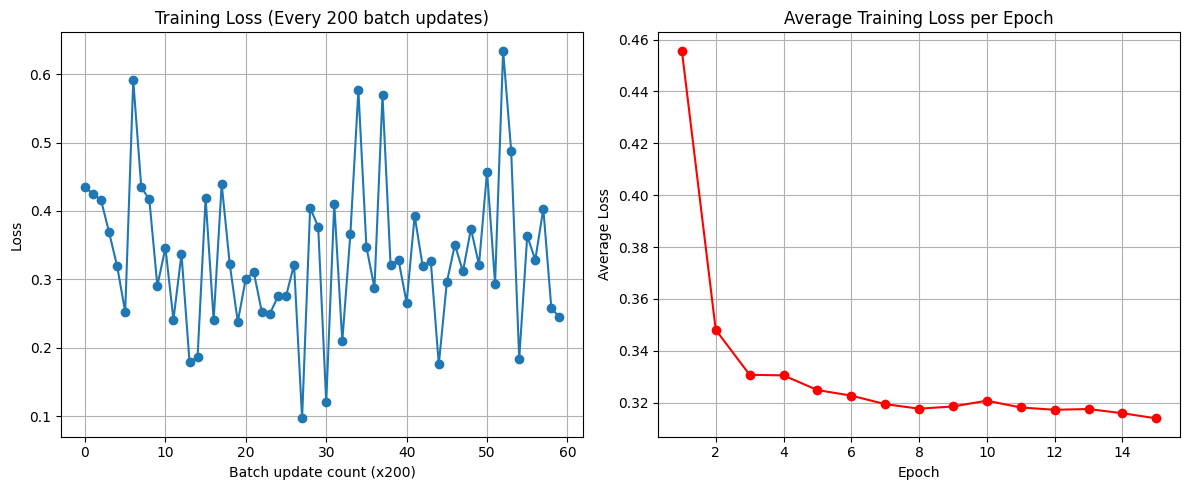

In [33]:
batch_losses_2, epoch_losses_2 = train_model(model_with_L2_2, train_loader, criterion, optimizer, num_epochs=15)
plot_training_curves(batch_losses_2, epoch_losses_2)

In [34]:
print("Evaluation on test data for model with L2 regularization with alpha = 0.01:")
evaluate_model(model_with_L2_2, test_loader)

Evaluation on test data for model with L2 regularization with alpha = 0.01:
Accuracy: 91.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.89      0.93      0.91      1032
           3       0.95      0.83      0.89      1010
           4       0.88      0.96      0.92       982
           5       0.87      0.91      0.89       892
           6       0.88      0.96      0.91       958
           7       0.94      0.91      0.93      1028
           8       0.91      0.89      0.90       974
           9       0.94      0.85      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Confusion Matrix:
[[ 923    0   12    0    0   13   27    1    4    0]
 [   0 1110    2    2    1    2    7    0   11    0]


np.float64(0.9165)

In [40]:
model_3 = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.01, weight_decay= 0.0001)

Epoch [1/25], Average Loss: 0.2804
Epoch [2/25], Average Loss: 0.1820
Epoch [3/25], Average Loss: 0.1769
Epoch [4/25], Average Loss: 0.1489
Epoch [5/25], Average Loss: 0.1472
Epoch [6/25], Average Loss: 0.1405
Epoch [7/25], Average Loss: 0.1445
Epoch [8/25], Average Loss: 0.1341
Epoch [9/25], Average Loss: 0.1378
Epoch [10/25], Average Loss: 0.1335
Epoch [11/25], Average Loss: 0.1341
Epoch [12/25], Average Loss: 0.1341
Epoch [13/25], Average Loss: 0.1358
Epoch [14/25], Average Loss: 0.1312
Epoch [15/25], Average Loss: 0.1354
Epoch [16/25], Average Loss: 0.1304
Epoch [17/25], Average Loss: 0.1285
Epoch [18/25], Average Loss: 0.1311
Epoch [19/25], Average Loss: 0.1255
Epoch [20/25], Average Loss: 0.1262
Epoch [21/25], Average Loss: 0.1282
Epoch [22/25], Average Loss: 0.1253
Epoch [23/25], Average Loss: 0.1294
Epoch [24/25], Average Loss: 0.1264
Epoch [25/25], Average Loss: 0.1283


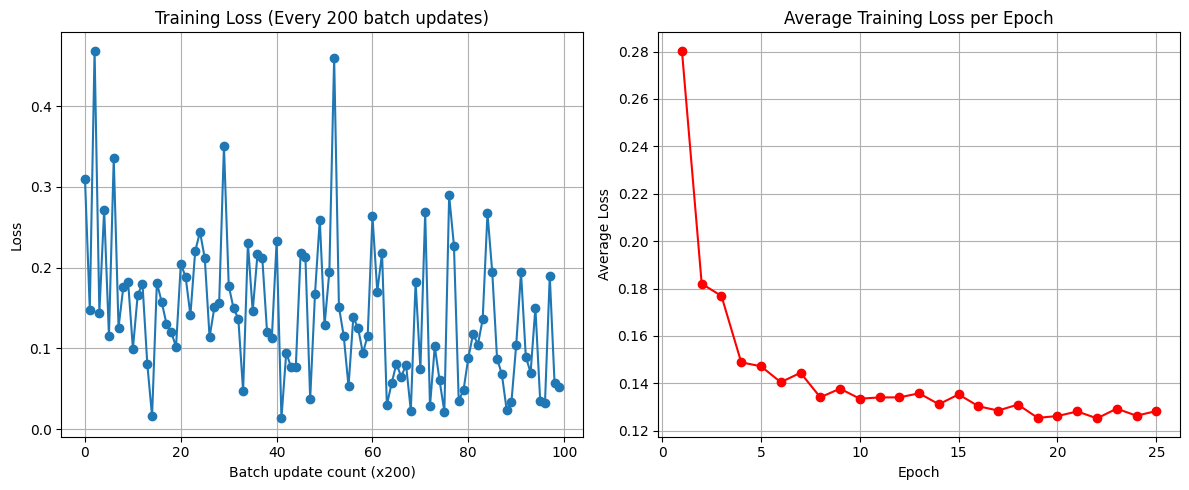

In [41]:
batch_losses_3, epoch_losses_3 = train_model(model_3, train_loader, criterion, optimizer, num_epochs=25)
plot_training_curves(batch_losses_3, epoch_losses_3)

In [42]:
print("Evaluation on test data for model with higher epoch (25) and L2 regularization of 0.0001:")
evaluate_model(model_3, test_loader)

Evaluation on test data for model with higher epoch (25) and L2 regularization of 0.0001:
Accuracy: 95.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.98      0.95      0.96      1032
           3       0.88      0.99      0.93      1010
           4       0.97      0.96      0.97       982
           5       0.99      0.93      0.96       892
           6       0.94      0.98      0.96       958
           7       0.98      0.94      0.96      1028
           8       0.93      0.95      0.94       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[ 964    0    0    1    0    0   11    1    3    0]
 [   0 1107    2    1    0    0    5   

np.float64(0.9595)

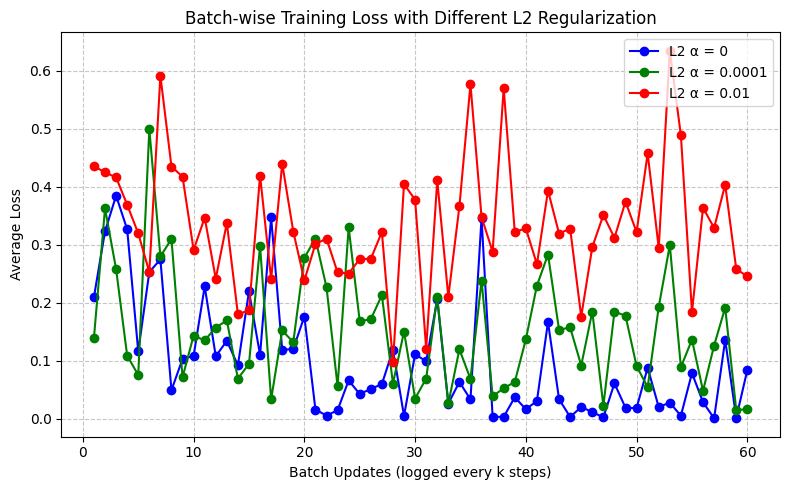

In [43]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(batch_losses)+1), batch_losses, marker='o', color='b', label="L2 α = 0")
plt.plot(range(1, len(batch_losses_1)+1), batch_losses_1, marker='o', color='g', label="L2 α = 0.0001")
plt.plot(range(1, len(batch_losses_2)+1), batch_losses_2, marker='o', color='r', label="L2 α = 0.01")
plt.title("Batch-wise Training Loss with Different L2 Regularization")
plt.xlabel("Batch Updates (logged every k steps)")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

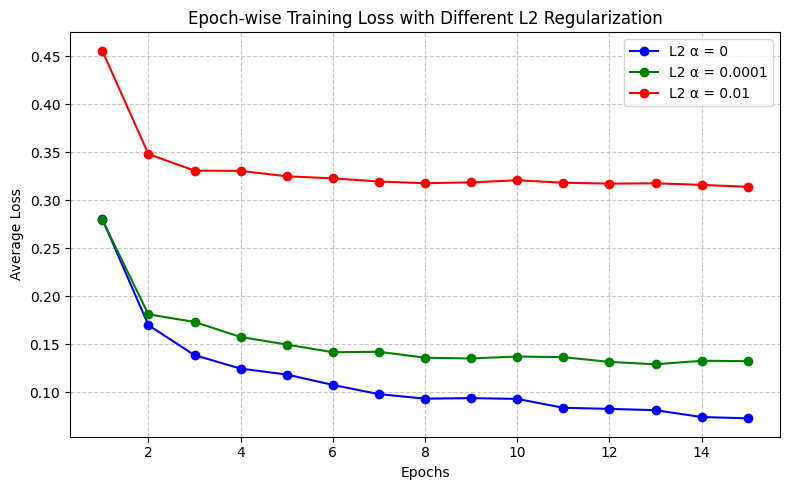

In [44]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', color='b', label="L2 α = 0")
plt.plot(range(1, len(epoch_losses_1)+1), epoch_losses_1, marker='o', color='g', label="L2 α = 0.0001")
plt.plot(range(1, len(epoch_losses_2)+1), epoch_losses_2, marker='o', color='r', label="L2 α = 0.01")
plt.title("Epoch-wise Training Loss with Different L2 Regularization")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# **Observations and Analysis for different values of Weight decay factor (alpha)**



*   In case of no L2 regularization -> **Test accuracy = 97.12%**
*   In case of L2 regularization with alpha of 0.0001 ->  **Test accuracy = 95.94%**
*   In case of L2 regularization with alpha of 0.01 -> **Test accuracy = 91.65%**


#Conclusions:-


*   L2 regularization increases the error in training phase and also reduces the accuracy on the test set.
*   But as a compensation, it minimizes the weights of the network
* **Lower is the value of the weight decay parameter (alpha) lesser will be the training loss and maximum will be the accuracy over the test data**



